<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LGBMRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Загрузим наш датасет и импортируем все необходимые библиотеки

In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import time as tm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV


data=pd.read_csv('/datasets/taxi.csv',
index_col=[0],
parse_dates=[0])

Посмотрим что получилось и выполним ресемплирование чтобы знать среднее количество заказов за 1 час

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Проверим индекс на монотонность

In [50]:
print(data.index.is_monotonic)

True


Выполним ресемпилирование - с каждых 10 минут переведем на час - и сделаем сумму наверное, хотя можно и среднее(с ним явно будут меньше значения, но это будет неправильно - заказ он либо есть(1), либо нет(0))

И посмотрим результаты

In [51]:
data=data.resample('1H').sum()

In [52]:
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


<AxesSubplot:xlabel='datetime'>

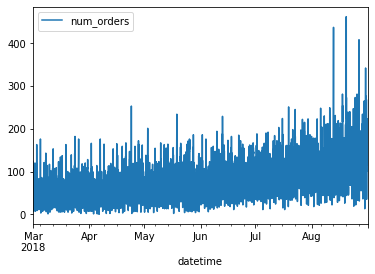

In [53]:
data.plot()

Отлично - получилось

Переходим к анализу

## Анализ

In [54]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Видим 2 колонки - дата (с интервалом в час) и количество заказов такси (усредненное в результате ресеплирования)

In [55]:
print(data.index.min())
print(data.index.max())

2018-03-01 00:00:00
2018-08-31 23:00:00


Нам даны данные с 3 января 2018 года по 31 августа 2018 года - тренд сезонности я думаю отпадает - в выборке меньше 1 года

In [56]:
decomposed = seasonal_decompose(data)

Заодно проверим выбросы - но по идее их тут не может быть, только возможно более 1000 в день при остальных значениях от 30 до 300

<AxesSubplot:>

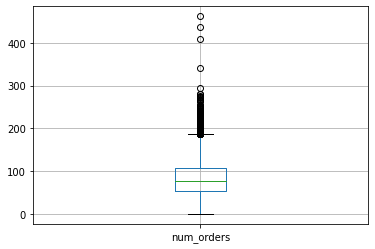

In [57]:
data.boxplot()

In [58]:
data.value_counts()

num_orders
73            65
57            58
66            58
78            54
84            52
              ..
232            1
238            1
239            1
240            1
462            1
Length: 251, dtype: int64

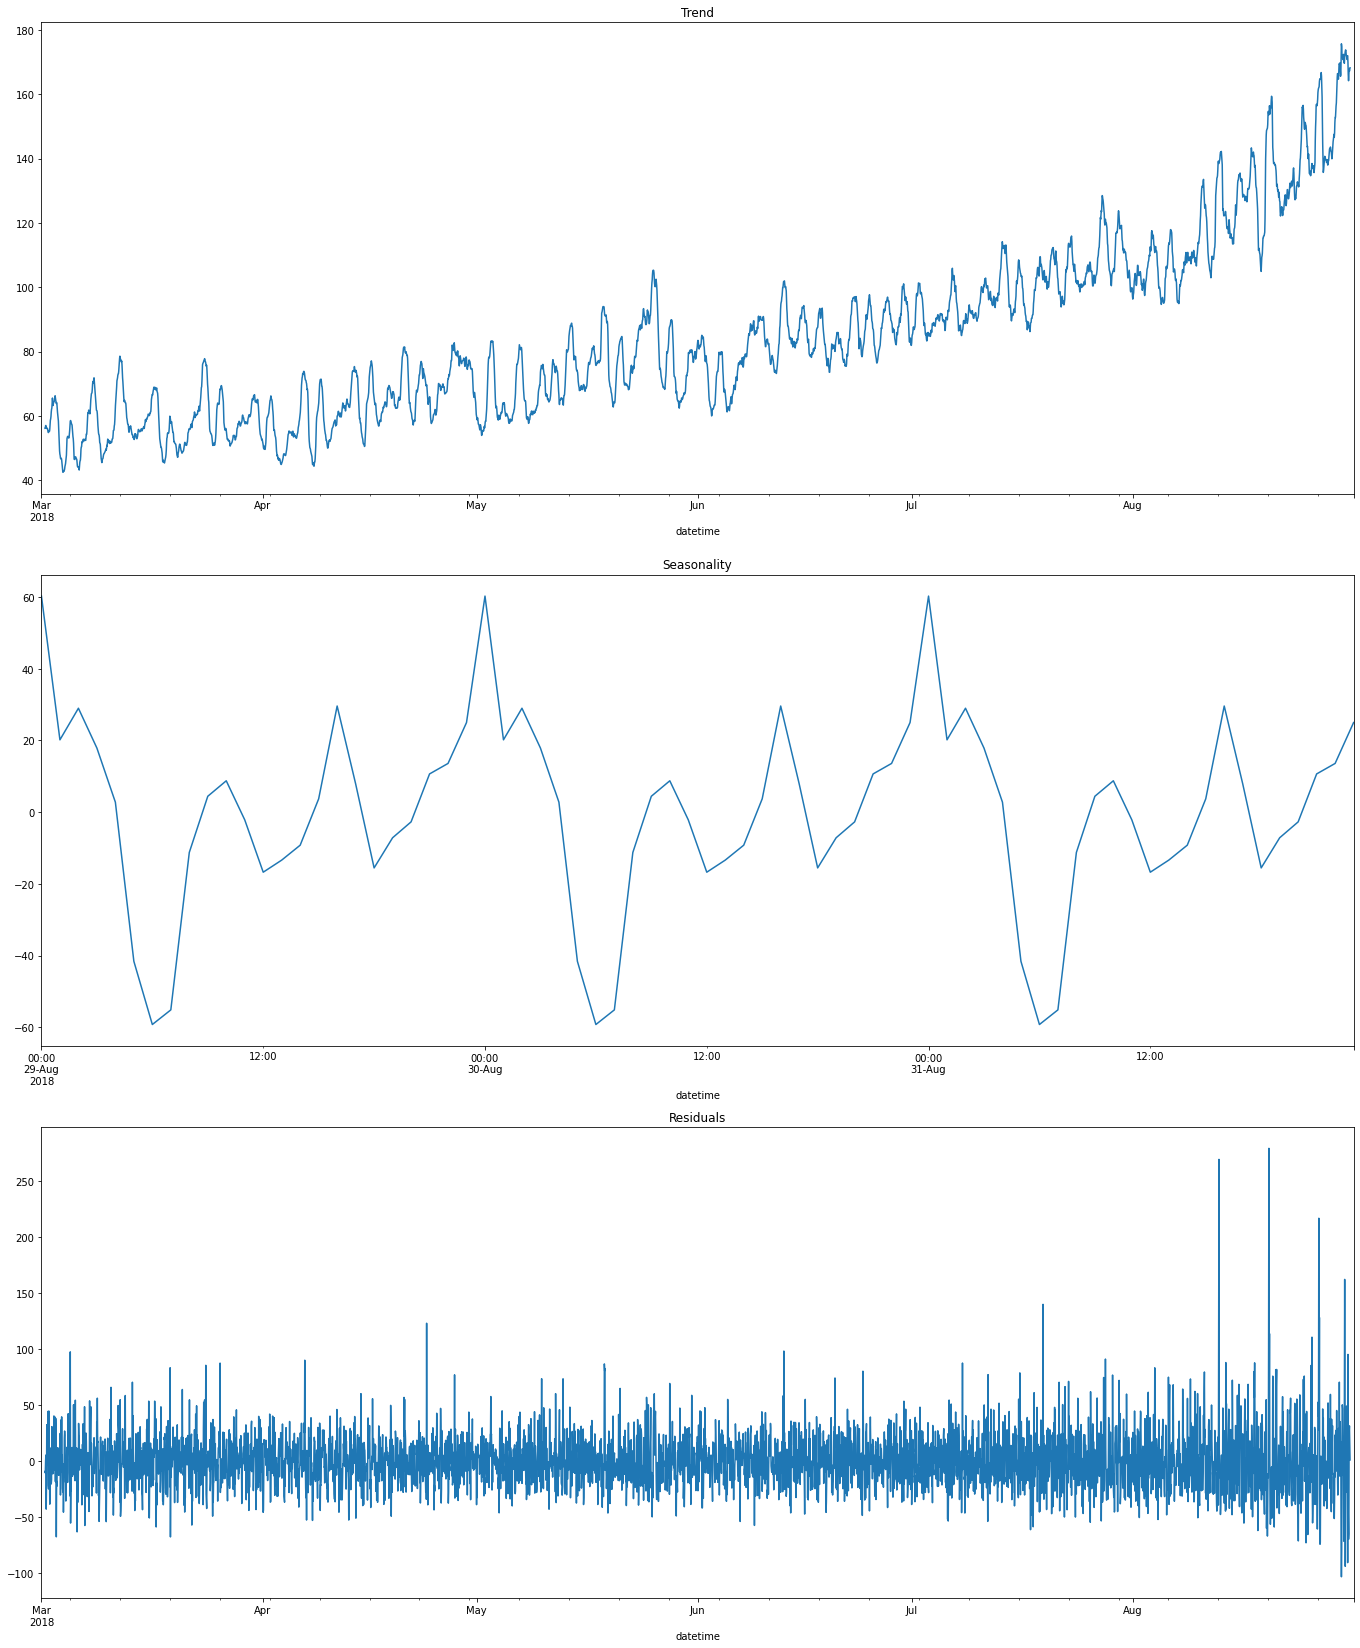

In [59]:
plt.figure(figsize=(19, 23))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-08-29':'2018-08-31'].plot(ax=plt.gca()) #посмотрим сезонность в рамках 1 дня - есть четкие закономерности
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

По данным графикам:
    
тренды - относительно весны, летом гораздо больше заказов такси - это логично. В теплое время года все летают в отпуск

сезонность нам не помогла, в выборке меньше года - посмотрел в рамках 1 дня - есть почти идентичные закономерности - ближе к полуночи максимальные значения, а к 6 часам затишься по заказам

## Обучение

Проверим 3 модели на выбор - Линейную регрерссию, Случайный лес с разными гиперпараметрами (применим подбор гиперпараметров) и бустинг

Создадим для моделирования больше признаков - для улучшения качества модели

Разделим наши данные на выборки, на тест возьмем 10% - по заданию
Создадим 3 выборки - тестовая для обучения, валидационная для выбора модели и тестовая для финального тестирования модели

In [60]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year #добавим год
    data['month'] = data.index.month #месяц
    data['day'] = data.index.day # день
    data['dayofweek'] = data.index.dayofweek #день недели
    data['hour'] = data.index.hour # час
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data


data_new = make_features(data, 10, 70) # создадим новый датафрейм и применим нащу функцию - далее разделим на 3 выборки

train, test = train_test_split(data_new, shuffle=False, test_size=0.1)
#valid, test = train_test_split(test, shuffle=False, test_size=0.2)
# Для моделей уберем пропуски - определим фичи и таргеты для каждой выборки
train = train.dropna()
features_train = train.drop(['num_orders','rolling_mean'], axis=1)
target_train = train['num_orders']
#features_valid = valid.drop(['num_orders','rolling_mean'], axis=1)
#target_valid = valid['num_orders']
features_test = test.drop(['num_orders','rolling_mean'], axis=1)
target_test = test['num_orders']


Проверим корреляцию признаков в датафрейме - из этого можно сделать вывод что скользящая средняя не нужна, она очень сильно коррелирует с лагами

In [61]:
data_new.corr()

,num_orders,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
num_orders,1.000000,NaN,5.101083e-01,1.653124e-01,-1.962844e-02,4.292046e-03,0.624138,0.465444,0.321173,0.248791,0.230489,0.238449,0.291733,0.310036,0.270676,0.263643,0.542172
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,0.510108,NaN,1.000000e+00,5.432905e-03,-1.196242e-02,5.821568e-16,0.510074,0.509825,0.509725,0.509330,0.509075,0.508222,0.507790,0.507692,0.507599,0.507150,0.900314
day,0.165312,NaN,5.432905e-03,1.000000e+00,-1.382657e-02,1.280062e-16,0.165201,0.165061,0.164633,0.164691,0.164018,0.164507,0.164888,0.165733,0.165958,0.166298,0.256819
dayofweek,-0.019628,NaN,-1.196242e-02,-1.382657e-02,1.000000e+00,2.160411e-18,-0.027331,-0.029567,-0.029056,-0.028695,-0.028752,-0.026911,-0.026913,-0.028955,-0.032041,-0.036656,0.007794
hour,0.004292,NaN,5.821568e-16,1.280062e-16,2.160411e-18,1.000000e+00,-0.076112,-0.120424,-0.154777,-0.146248,-0.123327,-0.074180,-0.100352,-0.196003,-0.207735,-0.178067,0.001120
lag_1,0.624138,NaN,5.100742e-01,1.652006e-01,-2.733141e-02,-7.611189e-02,1.000000,0.623446,0.464959,0.320580,0.248332,0.229212,0.237082,0.290651,0.309875,0.270271,0.557067
lag_2,0.465444,NaN,5.098245e-01,1.650606e-01,-2.956675e-02,-1.204245e-01,0.623446,1.000000,0.623151,0.464503,0.320169,0.246899,0.227617,0.235748,0.290485,0.309489,0.565050
lag_3,0.321173,NaN,5.097252e-01,1.646332e-01,-2.905576e-02,-1.547765e-01,0.464959,0.623151,1.000000,0.622932,0.464285,0.319511,0.246106,0.226904,0.235568,0.290205,0.571313
lag_4,0.248791,NaN,5.093300e-01,1.646910e-01,-2.869538e-02,-1.462479e-01,0.320580,0.464503,0.622932,1.000000,0.622791,0.463843,0.318875,0.245466,0.226730,0.235281,0.573668


Проверим корректность выборок - где заканчивается трейн должен начинаться валид, где заанчивается валид начинается тест

In [62]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-03 22:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


Также проверим размер выборок

In [63]:
print(train.shape)
print(test.shape)

(3904, 17)
(442, 17)


### LinearRegression

In [64]:
model = LinearRegression()

In [65]:
%%time
model.fit(features_train, target_train)

CPU times: user 5.86 ms, sys: 17 µs, total: 5.88 ms
Wall time: 4.06 ms


LinearRegression()

In [66]:
%%time
predicted_valid = model.predict(features_test)

CPU times: user 8.66 ms, sys: 92 µs, total: 8.76 ms
Wall time: 2.17 ms


In [67]:
mse = mean_squared_error(target_test, predicted_valid)
print("Linear Regression")
print("RMSE =", mse ** 0.5)

Linear Regression
RMSE = 53.34912075133917


### RandomForestRegressor

In [68]:
model = RandomForestRegressor()
tscv = TimeSeriesSplit(n_splits=2)
param_search = {'max_depth' : [3,400],
               'n_estimators':[2,200]}
grid = GridSearchCV(estimator=model, cv=tscv,
                        param_grid=param_search, verbose=2)
grid.fit(features_train, target_train)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] END ........................max_depth=3, n_estimators=2; total time=   0.0s
[CV] END ........................max_depth=3, n_estimators=2; total time=   0.0s
[CV] END ......................max_depth=3, n_estimators=200; total time=   0.6s
[CV] END ......................max_depth=3, n_estimators=200; total time=   0.9s
[CV] END ......................max_depth=400, n_estimators=2; total time=   0.0s
[CV] END ......................max_depth=400, n_estimators=2; total time=   0.0s
[CV] END ....................max_depth=400, n_estimators=200; total time=   1.7s
[CV] END ....................max_depth=400, n_estimators=200; total time=   3.5s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': [3, 400], 'n_estimators': [2, 200]},
             verbose=2)

In [69]:
print(grid.best_params_)

{'max_depth': 400, 'n_estimators': 200}


In [70]:
model = RandomForestRegressor(n_estimators=200, max_depth=400, random_state=12345)

In [71]:
%%time
model.fit(features_train, target_train)

CPU times: user 5.09 s, sys: 72.9 ms, total: 5.16 s
Wall time: 5.17 s


RandomForestRegressor(max_depth=400, n_estimators=200, random_state=12345)

In [72]:
%%time
predicted_valid = model.predict(features_test)

CPU times: user 34.7 ms, sys: 11 µs, total: 34.7 ms
Wall time: 33 ms


In [73]:
mse = mean_squared_error(target_test, predicted_valid) 
print("RandomForestRegressor с выбранными гиперпараметрами")
print("RMSE =", mse ** 0.5)

RandomForestRegressor с выбранными гиперпараметрами
RMSE = 44.47790409026086


### LGBMRegressor

In [74]:
model = lgb.LGBMRegressor(num_leaves=15, max_depth=17, metric='rmse')

In [75]:
%%time
model.fit(features_train, target_train)

CPU times: user 2min 13s, sys: 1.56 s, total: 2min 15s
Wall time: 2min 15s


LGBMRegressor(max_depth=17, metric='rmse', num_leaves=15)

In [76]:
%%time
predicted_valid = model.predict(features_test)

CPU times: user 37.6 ms, sys: 0 ns, total: 37.6 ms
Wall time: 16.8 ms


In [77]:
mse = mean_squared_error(target_test, predicted_valid) 
print("LGBMRegressor")
print("RMSE =", mse ** 0.5)

LGBMRegressor
RMSE = 42.248900643515846


## Тестирование

Лучший результат показала модель LGBMRegressor с параметрами num_leaves=15, max_depth=17, metric='rmse'

Проверим ее на тесте

In [78]:
model = lgb.LGBMRegressor(num_leaves=15, max_depth=17, metric='rmse')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_test)
mse = mean_squared_error(target_test, predicted_valid) 
print("LGBMRegressor финальный")
print("RMSE =", mse ** 0.5)

LGBMRegressor финальный
RMSE = 42.248900643515846


## Вывод

- Загрузил и посмотрел данные в таблице
- Провел декомпозицию и вывел графики - обнаружил следующие закономерности: ближе к лету и летом количество заказов такси растет, в рамках одного дня также есть зависимость - в 00-00 заказов существенно больше чем в 06-00
- добавил признаки для обучения (год, месяц, день недели и час), а также скользящее среднее за 24 часа и сдвиг (лаг) в рамках недели - 7 дней
- провел обучение и выбор модели из линейной регрессии, случайного леса и бустинга
- Далее протестировал модель и результат итоговой метрики RMSE = 42.248900643515846, что ниже нужных 48 - задача выполнена

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48